In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import pickle,sys,os
from numpy import *
import ruptures as rpt
from scipy.stats import norm, pearsonr, zscore, rankdata
from sklearn.decomposition import PCA
import pingouin as pg

In [2]:
with open('../../Human_hg38_chrom_ends.pkl','rb') as a:
    ENDS = pickle.load(a)

with open('../../Human_hg38_auto_10kb_windows.pkl','rb') as b:
    W = pickle.load(b)

In [3]:
df = pd.read_csv('3202_sequence_index.tsv',sep='\t')
runs = df['RUN_NAME'].tolist()
files = df['LIBRARY_NAME'].tolist()
sorted_files = sorted(files)
batches = [x.split('-')[-2] for x in runs]
bs = unique(batches)
BATCHES = {}
for batch in bs:
    idxs = [i for i in range(len(batches)) if batches[i]==batch]
    samples = array(files)[idxs]
    BATCHES[batch] = list(samples)

In [4]:
def get_numpy_arr(infile,columns=None):
    arr_file = load(infile)
    if columns is None:
        arr = arr_file['arr']
    else:
        arr = arr_file['arr'][:,columns]
    for cols in range(arr.shape[1]):
        csum = sum(arr[:,cols])
        arr[:,cols] /= csum
    return arr

def get_full_table(arr,win=10000):
    rows = 0
    full_table = []
    for ch in range(22):
        chrom = 'chr'+str(ch+1)
        bound = ENDS[chrom]
        windows = bound // win
        full_table.append(arr[rows:rows+windows,:])
        rows += windows
    if rows!=arr.shape[0]:
        print('error')
    return full_table

def get_full_table_array_k_chr(full_table,win=10000,k=1):
    ends = []
    if k == 1:
        for ch in range(22):
            if ch == 0:
                arr = full_table[ch]
            else:
                arr = concatenate((arr,full_table[ch]),axis=0)
            ends.append(arr.shape[0])
    else:
        ft = []
        for ch in range(22):
            chrom = 'chr'+str(ch+1)
            bound = ENDS[chrom]
            win2 = win*k
            windows2 = bound // win2
            arr_i = full_table[ch]
            arr_k = zeros((windows2,arr_i.shape[1]))
            for j in range(windows2-1):
                arr_k[j] = arr_i[j*k:(j+1)*k,:].sum(axis=0)
            arr_k[-1] = arr_i[(windows2-1)*k:,:].sum(axis=0)
            if ch==0:
                arr = arr_k
            else:
                arr = concatenate((arr,arr_k),axis=0)
            ends.append(arr.shape[0])
    return arr, ends

def get_arr(infile,columns=None,k=1):
    df_arr = get_numpy_arr(infile,columns)
    table = get_full_table(df_arr)
    ftk, ends = get_full_table_array_k_chr(table,k=k)
    print(ends)
    return ftk #arrs

In [5]:
k = 1
thgs = get_arr('merged_table_no_correction_1000g_10kb.npz',k=k)
thgs.shape

[24895, 49114, 68943, 87964, 106117, 123197, 139131, 153644, 167483, 180862, 194370, 207697, 219133, 229837, 240036, 249069, 257394, 265431, 271292, 277736, 282406, 287487]


(287487, 3202)

In [6]:
brcas = get_arr('../../merged_table_no_correction_brca_10kb.npz',k=k)
crcs = get_arr('../../merged_table_no_correction_crc_10kb.npz',k=k)
ctrl29s = get_arr('../../merged_table_no_correction_ctrl29_10kb.npz',k=k)

ctrl38s = get_arr('../../merged_table_no_correction_ctrl38_10kb.npz',k=k)
ctdna36s = get_arr('../../merged_table_no_correction_ctdna36luad_10kb.npz',k=k)

ega8460 = get_arr('../../merged_table_no_correction_EGA8460_10kb.npz',k=k)
ega5343_ctrl = get_arr('../../merged_table_no_correction_EGA5343_ctrl_10kb.npz',k=k)

[24895, 49114, 68943, 87964, 106117, 123197, 139131, 153644, 167483, 180862, 194370, 207697, 219133, 229837, 240036, 249069, 257394, 265431, 271292, 277736, 282406, 287487]
[24895, 49114, 68943, 87964, 106117, 123197, 139131, 153644, 167483, 180862, 194370, 207697, 219133, 229837, 240036, 249069, 257394, 265431, 271292, 277736, 282406, 287487]
[24895, 49114, 68943, 87964, 106117, 123197, 139131, 153644, 167483, 180862, 194370, 207697, 219133, 229837, 240036, 249069, 257394, 265431, 271292, 277736, 282406, 287487]
[24895, 49114, 68943, 87964, 106117, 123197, 139131, 153644, 167483, 180862, 194370, 207697, 219133, 229837, 240036, 249069, 257394, 265431, 271292, 277736, 282406, 287487]
[24895, 49114, 68943, 87964, 106117, 123197, 139131, 153644, 167483, 180862, 194370, 207697, 219133, 229837, 240036, 249069, 257394, 265431, 271292, 277736, 282406, 287487]
[24895, 49114, 68943, 87964, 106117, 123197, 139131, 153644, 167483, 180862, 194370, 207697, 219133, 229837, 240036, 249069, 257394, 26

In [7]:
arr_file = load('../../merged_table_no_correction_EGA7080_10kb.npz')
samples = arr_file['samples']

ctrl = [i for i in range(len(samples)) if samples[i].startswith('Ctrl')]
ctdna = [i for i in range(len(samples)) if i not in ctrl] # and samples[i].endswith('_1')
ega7080_ctrl = get_arr('../../merged_table_no_correction_EGA7080_10kb.npz',columns=ctrl,k=k)
ega7080_ctdna = get_arr('../../merged_table_no_correction_EGA7080_10kb.npz',columns=ctdna,k=k)

[24895, 49114, 68943, 87964, 106117, 123197, 139131, 153644, 167483, 180862, 194370, 207697, 219133, 229837, 240036, 249069, 257394, 265431, 271292, 277736, 282406, 287487]
[24895, 49114, 68943, 87964, 106117, 123197, 139131, 153644, 167483, 180862, 194370, 207697, 219133, 229837, 240036, 249069, 257394, 265431, 271292, 277736, 282406, 287487]


In [8]:
import gzip
nucleosomes = {}
# download at https://generegulation.org/NGS/stable_nucs/hg38/GSE81314_healthy_Song_stable_100bp_hg38.bed.gz
with gzip.open('GSE81314_healthy_Song_stable_100bp_hg38.bed.gz','r') as f:        
    for lines in f:        
        content = lines.decode().strip().split('\t')
        chrom = content[0]
        reg = (content[1],content[2])
        if chrom not in nucleosomes:
            nucleosomes[chrom] = []
        nucleosomes[chrom].append(reg)

allgenes = {}; pcgenes = {}; ncgenes={}
with open('Allgenes.bed','r') as f:        
    for lines in f:        
        content = lines.strip().split('\t')
        chrom = content[0]
        reg = (content[1],content[2])
        gtype = content[9].split('gene_type=')[1].split(';')[0]
        if gtype == 'protein_coding':
            if chrom not in pcgenes:
                pcgenes[chrom]=[]
            pcgenes[chrom].append(reg)
        else:
            if chrom not in ncgenes:
                ncgenes[chrom]=[]
            ncgenes[chrom].append(reg)
        if chrom not in allgenes:
            allgenes[chrom] = []
        allgenes[chrom].append(reg)

In [9]:
gcdict = {}
with open('gc_content10kb.txt','r') as f:        
    for lines in f:
        if lines.startswith('#'):
            continue
        content = lines.strip().split('\t')
        chrom = content[0]
        start = int(content[1])
        end = int(content[2])-1
        gc = float(content[4])
        record = (start,end,gc)
        if chrom not in gcdict:
            gcdict[chrom]=[]
        gcdict[chrom].append(record)

In [10]:
def get_gc_table(gcdict,size,win=10000):
    arr = zeros(size)
    offset = 0
    for ch in range(22):
        chrom = 'chr'+str(ch+1)
        bound = ENDS[chrom]
        windows = bound // win
        for r in gcdict[chrom]:
            start = r[0];end = r[1];gc = r[2]
            w = start // win
            if offset+w>size:
                print(chrom,w)
                continue
            arr[offset+w]+=gc
        offset += windows
    if offset!=size:
        print('unmatched size',size,offset)
    return arr

In [11]:
def get_gene_table(genedict,size,win=10000):
    arr = zeros(size)
    offset = 0
    for ch in range(22):
        chrom = 'chr'+str(ch+1)
        bound = ENDS[chrom]
        windows = bound // win
        for r in genedict[chrom]:
            start = int(r[0])
            end = int(r[1])
            w1 = start // win
            w2 = end // win
            if offset+w1>size:
                continue
            for j in range(w1,w2+1):
                arr[offset+j]+=1
        offset += windows
    if offset!=size:
        print('unmatched size',size,offset)
    return arr

In [12]:
def get_nucleosome_table(size,win=10000):
    arr = zeros(size)
    offset = 0
    for ch in range(22):
        chrom = 'chr'+str(ch+1)
        bound = ENDS[chrom]
        windows = bound // win
        for r in nucleosomes[chrom]:
            start = int(r[0])
            end = int(r[1])
            w1 = start // win
            w2 = end // win
            if offset+w1>size:
                continue
            if w1 == w2:
                arr[offset+w1]+=1
            else:
                #print(chrom,r)
                arr[offset+w1]+=1;arr[offset+w2]+=1
        offset += windows
    if offset!=size:
        print('unmatched size',size,offset)
    return arr

In [13]:
ends = [24895, 49114, 68943, 87964, 106117, 123197,139131, 153644, 167483, 180862, 
        194370, 207697, 219133, 229837, 240036, 249069, 257394, 265431, 271292, 277736, 282406, 287487]
feats = [i for i in range(thgs.shape[0]) if sum(thgs[i,:])>0]
print(ends[-1]-len(feats))
#zf = [i for i in range(thgs.shape[0]) if i not in feats]
#print(len(zf))
chr_splits = [0]
j = 0
for e in ends:
    for i in range(j,len(feats)):
        if feats[i] > e:
            chr_splits.append(i)
            j = i
            break
chr_splits.append(len(feats))
print(chr_splits)

51248
[0, 21838, 43007, 61151, 77732, 93356, 108799, 122508, 135682, 146854, 158478, 170121, 181337, 190291, 197701, 205137, 211316, 216730, 222093, 226049, 231029, 233445, 236239]


In [14]:
gc = get_gc_table(gcdict,287487)
nucleosome = get_nucleosome_table(287487)
allgene = get_gene_table(allgenes,287487)
pcgene = get_gene_table(pcgenes,287487)
ncgene = get_gene_table(ncgenes,287487)

In [15]:
gc = gc[feats]
nucleosome = nucleosome[feats]
allgene = allgene[feats]
pcgene = pcgene[feats]
ncgene = ncgene[feats]

In [16]:
def get_rank(arr):
    ranked_arr = []
    for i in range(arr.shape[1]):
        ranked = rankdata(arr[:,i],'min')
        ranked_arr.append(ranked)
    return array(ranked_arr).T

In [17]:
rctrl38s = get_rank(ctrl38s[feats,:])
rctdna36s = get_rank(ctdna36s[feats,:])
rpost22s = get_rank(post22s[feats,:])
rbrcas = get_rank(brcas[feats,:])
rcrcs = get_rank(crcs[feats,:])
rctrl29s = get_rank(ctrl29s[feats,:])
rega5343_ctrl = get_rank(ega5343_ctrl[feats,:])
rega7080_ctrl = get_rank(ega7080_ctrl[feats,:])
rega8460 = get_rank(ega8460[feats,:])
rega7080_ctdna = get_rank(ega7080_ctdna[feats,:])
#rthgs = get_rank(thgs[feats,:])

In [18]:
rthgs = get_rank(thgs[feats,:])

In [19]:
# segmentation
def get_breakpoints(arr=rthgs,splits=chr_splits):
    bkps = {}
    breaks = [0]
    offset = 0
    for ch in range(22):
        ctrl_signals = mean(arr[splits[ch]:splits[ch+1],:],axis=1)
        sigma = std(ctrl_signals)
        n = len(ctrl_signals)
        if n < 100:
            offset+=n
            continue
        algo = rpt.Binseg(model="l1",min_size=100).fit(ctrl_signals) # min size is 1Mbp # "l1", "rbf", "linear", "normal", "ar",...
        my_bkps = algo.predict(pen=log(n)*sigma)
        bkps['chr'+str(ch+1)] = [offset]+[x+offset for x in my_bkps]
        breaks += [x+offset for x in my_bkps]
        offset+= n
    return bkps, breaks
bkps, breaks = get_breakpoints()

In [20]:
rctrls = hstack((rctrl29s,rega7080_ctrl,rega5343_ctrl,rctrl38s))

In [21]:
rctdnas = hstack((rctdna36s,rega7080_ctdna,rbrcas,rcrcs,rega8460))

In [22]:
len(breaks)

1091

In [23]:
len(allgene)

236239

In [24]:
import matplotlib.ticker as tkr
formatter = tkr.ScalarFormatter(useMathText=True)
formatter.set_scientific(True)
formatter.set_powerlimits((-1, 3))

import matplotlib as mpl
cmap = mpl.colormaps['Spectral_r']
# Take colors at regular intervals spanning the colormap.
colors = cmap(linspace(0, 1, 4))

In [25]:
def sort_arr_by_chr_mean(arr,chrom='chr1',breaks=bkps['chr1']):
    i = int(chrom.split('hr')[1])-1
    m = mean(arr[breaks[0]:breaks[-1],:],axis=0)
    sorted_idx = argsort(m)
    return sorted_idx

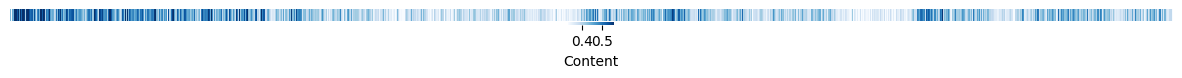

In [26]:
plt.figure(figsize=(15,.2))
chrom='chr1'
arr2 = array([gc,pcgene,ncgene,nucleosome])
ch = int(chrom.split('hr')[1])-1
ax = sns.heatmap(arr2[:1,chr_splits[ch]:chr_splits[ch+1]],cbar_kws = dict(label='Content',location="bottom",pad=.1,shrink=.25),
                 robust=True,cmap='Blues');ax.tick_params(left=False,bottom=False,pad=0);ax.set(xticklabels=[],yticklabels=[])
plt.show()
#plt.savefig('new_figures/fig.gc_heatmap.png',bbox_inches='tight',dpi=120)

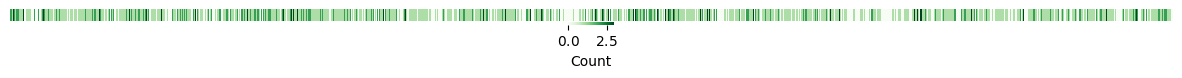

In [27]:
plt.figure(figsize=(15,.2))
arr2 = array([allgene,pcgene,ncgene,nucleosome])
ch = int(chrom.split('hr')[1])-1
ax = sns.heatmap(arr2[:1,chr_splits[ch]:chr_splits[ch+1]],cbar_kws = dict(label='Count',location="bottom",pad=.1,shrink=.25,format=formatter),
                 robust=True,cmap='Greens');ax.tick_params(left=False,bottom=False,pad=0);ax.set(xticklabels=[],yticklabels=[])
plt.show()
#plt.savefig('new_figures/fig1.All_gene_heatmap.png',bbox_inches='tight',dpi=120)

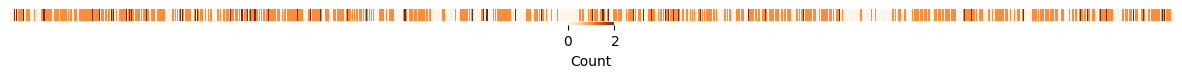

In [28]:
plt.figure(figsize=(15,.2))
ch = int(chrom.split('hr')[1])-1
ax = sns.heatmap(arr2[1:2,chr_splits[ch]:chr_splits[ch+1]],cbar_kws = dict(label='Count',location="bottom",pad=.1,shrink=.25,format=formatter),
                 robust=True,cmap='Oranges');ax.tick_params(left=False,bottom=False,pad=0);ax.set(xticklabels=[],yticklabels=[])
plt.show()
#plt.savefig('new_figures/fig.pc_gene_heatmap.png',bbox_inches='tight',dpi=120)

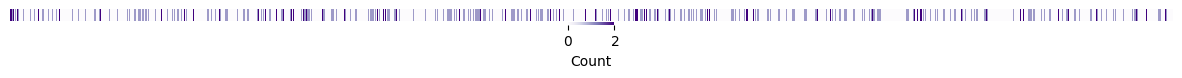

In [29]:
plt.figure(figsize=(15,.2))
ch = int(chrom.split('hr')[1])-1
ax = sns.heatmap(arr2[2:3,chr_splits[ch]:chr_splits[ch+1]],cbar_kws = dict(label='Count',location="bottom",pad=.1,shrink=.25,format=formatter),
                 robust=True,cmap='Purples');ax.tick_params(left=False,bottom=False,pad=0);ax.set(xticklabels=[],yticklabels=[])
plt.show()
#plt.savefig('new_figures/fig.nc_gene_heatmap.png',bbox_inches='tight',dpi=120)

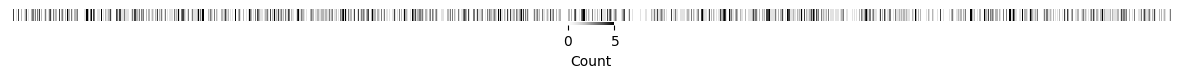

In [30]:
plt.figure(figsize=(15,.2))
ch = int(chrom.split('hr')[1])-1
ax = sns.heatmap(arr2[3:4,chr_splits[ch]:chr_splits[ch+1]],cbar_kws = dict(label='Count',location="bottom",pad=.1,shrink=.25,format=formatter),
                 robust=True,cmap='Greys');ax.tick_params(left=False,bottom=False,pad=0);ax.set(xticklabels=[],yticklabels=[])
plt.show()
#plt.savefig('new_figures/fig.nucleosome_heatmap.png',bbox_inches='tight',dpi=120)

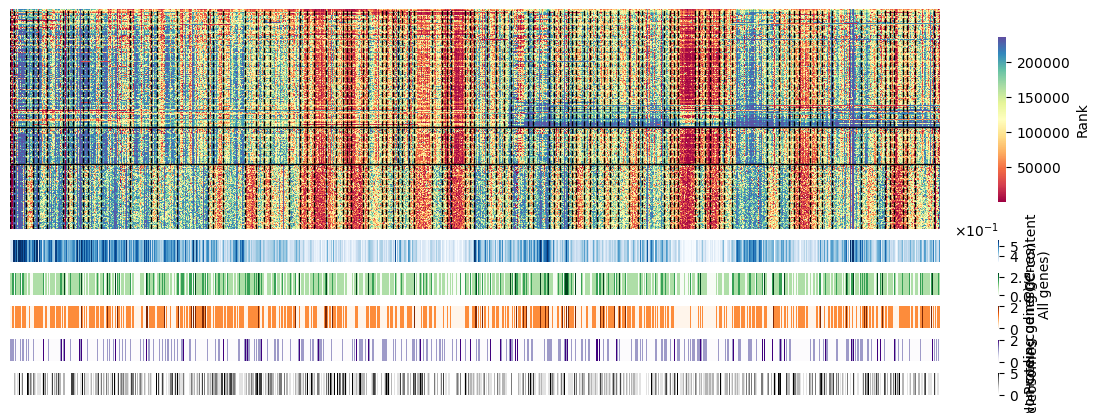

In [31]:
#plt.figure()
chrom='chr1'
idx1 = sort_arr_by_chr_mean(rctdnas)
idx2 = sort_arr_by_chr_mean(rctrls)
idx3 = sort_arr_by_chr_mean(rthgs[:,:200])
arr = vstack((rctdnas.T[idx1,:],rctrls.T[idx2,:],rthgs.T[:200,:][idx3,:]))
ch = int(chrom.split('hr')[1])-1
f, (a0, a1, a2, a3, a4, a5) = plt.subplots(6, 1, figsize=(15,5), height_ratios=[10, 1, 1, 1, 1, 1])
#plt.title(chrom)
sns.heatmap(arr[:,chr_splits[ch]:chr_splits[ch+1]],cbar_kws = dict(label='Rank',location="right",shrink=.75,format=formatter),
                 robust=True,cmap="Spectral",vmin=1,vmax=236239,ax=a0)
a0.tick_params(left=False,bottom=False,pad=0);a0.set(xticklabels=[],yticklabels=[]) #ylabel='gDNA  cfDNA',
a0.hlines([rctdnas.shape[1],rctdnas.shape[1]+rctrls.shape[1]], *a0.get_xlim(),colors='black',linewidth=1)
a0.vlines([x-bkps[chrom][0] for x in bkps[chrom]],colors='black',linewidth=1,linestyles='dashed',*a0.get_ylim())

arr2 = array([gc,allgene,pcgene,ncgene,nucleosome])
sns.heatmap(arr2[:1,chr_splits[ch]:chr_splits[ch+1]],cbar_kws = dict(label='GC-content',location="right",shrink=1,format=formatter),
                 robust=True,cmap='Blues',ax=a1)
a1.tick_params(left=False,bottom=False,pad=0);a1.set(xticklabels=[],yticklabels=[])

sns.heatmap(arr2[1:2,chr_splits[ch]:chr_splits[ch+1]],cbar_kws = dict(label='All genes)',location="right",shrink=1,format=formatter),
                 robust=True,cmap='Greens',ax=a2)
a2.tick_params(left=False,bottom=False,pad=0);a2.set(xticklabels=[],yticklabels=[])

sns.heatmap(arr2[2:3,chr_splits[ch]:chr_splits[ch+1]],cbar_kws = dict(label='Protein-coding genes)',location="right",shrink=1,format=formatter),
                 robust=True,cmap='Oranges',ax=a3)
a3.tick_params(left=False,bottom=False,pad=0);a3.set(xticklabels=[],yticklabels=[])

sns.heatmap(arr2[3:4,chr_splits[ch]:chr_splits[ch+1]],cbar_kws = dict(label='Non-coding genes)',location="right",shrink=1,format=formatter),
                 robust=True,cmap='Purples',ax=a4)
a4.tick_params(left=False,bottom=False,pad=0);a4.set(xticklabels=[],yticklabels=[])

sns.heatmap(arr2[4:5,chr_splits[ch]:chr_splits[ch+1]],cbar_kws = dict(label='Nucleosomes',location="right",shrink=1,format=formatter),
                 robust=True,cmap='Greys',ax=a5)
a5.tick_params(left=False,bottom=False,pad=0);a5.set(xticklabels=[],yticklabels=[])
plt.show()
#plt.savefig('new_figures/fig.chr1-window-vs-gc-genes-nucleosome-heatmap.png',bbox_inches='tight',dpi=120)

In [37]:
def segment_vs_genes(arr=rctrls,breaks=breaks,ref=rthgs):
    n = len(breaks)-1
    refseg = []; arrseg = []; nucseg = []; agseg = []; pcgseg = []; ncgseg = []; gcseg = []
    for i in range(n):
        ref_seg = median(mean(ref[breaks[i]:breaks[i+1],:],axis=0));refseg.append(ref_seg)
        arr_seg = median(mean(arr[breaks[i]:breaks[i+1],:],axis=0));arrseg.append(arr_seg)
        nuc_seg = mean(nucleosome[breaks[i]:breaks[i+1]]);nucseg.append(nuc_seg)
        allgene_seg = mean(allgene[breaks[i]:breaks[i+1]]);agseg.append(allgene_seg)
        pcgene_seg = mean(pcgene[breaks[i]:breaks[i+1]]);pcgseg.append(pcgene_seg)
        ncgene_seg = mean(ncgene[breaks[i]:breaks[i+1]]);ncgseg.append(ncgene_seg)
        gc_seg = mean(gc[breaks[i]:breaks[i+1]]);gcseg.append(gc_seg)
    return refseg,arrseg,nucseg,agseg,pcgseg,ncgseg,gcseg

refseg,arrseg,nucseg,agseg,pcgseg,ncgseg,gcseg = segment_vs_genes()

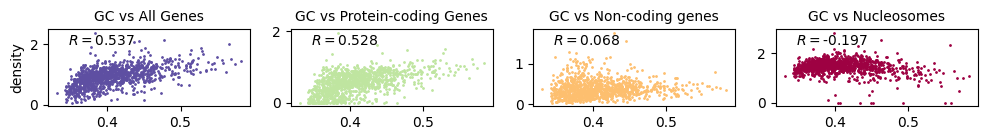

In [38]:
r1 = pearsonr(gcseg,agseg)[0]; r2 = pearsonr(gcseg,pcgseg)[0]; r3 = pearsonr(gcseg,ncgseg)[0]; r4 = pearsonr(gcseg,nucseg)[0]

f, (a1, a2, a3, a4) = plt.subplots(1, 4, figsize=(12,1), width_ratios=[1, 1, 1, 1])
#a0.scatter(agseg,refseg,s=1,color=colors[0]);a0.set_title('All Genes',fontsize=10);a0.annotate('R='+str(round(r0,3)), (0.1, 0.8), xycoords='axes fraction')
a1.scatter(gcseg,agseg,s=1,color=colors[0]);a1.set_title('GC vs All Genes',fontsize=10);a1.annotate(r'$R=$'+str(round(r1,3)), (0.1, 0.8), xycoords='axes fraction')
a2.scatter(gcseg,pcgseg,s=1,color=colors[1]);a2.set_title('GC vs Protein-coding Genes',fontsize=10);a2.annotate(r'$R=$'+str(round(r2,3)), (0.1, 0.8), xycoords='axes fraction')
a3.scatter(gcseg,ncgseg,s=1,color=colors[2]);a3.set_title('GC vs Non-coding genes',fontsize=10);a3.annotate(r'$R=$'+str(round(r3,3)), (0.1, 0.8), xycoords='axes fraction')
a4.scatter(gcseg,nucseg,s=1,color=colors[3]);a4.set_title('GC vs Nucleosomes',fontsize=10);a4.annotate(r'$R=$'+str(round(r4,3)), (0.1, 0.8), xycoords='axes fraction')
#a0.ticklabel_format(axis='y', style='sci', scilimits=(1,3))
a1.ticklabel_format(axis='y', style='sci', scilimits=(1,3));a1.set_ylabel('density')
a2.ticklabel_format(axis='y', style='sci', scilimits=(1,3))
a3.ticklabel_format(axis='y', style='sci', scilimits=(1,3))
a4.ticklabel_format(axis='y', style='sci', scilimits=(1,3))
plt.show()
#plt.savefig('new_suppl/GC-confounder-effects.png',bbox_inches='tight',dpi=120)

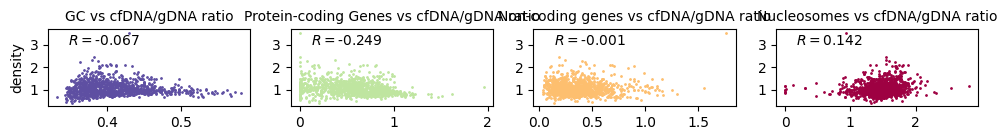

In [40]:
ratio = [arrseg[i]/refseg[i] for i in range(len(refseg))]
r1 = pearsonr(gcseg,ratio)[0]; 
r2 = pearsonr(pcgseg,ratio)[0]; 
r3 = pearsonr(ncgseg,ratio)[0]; 
r4 = pearsonr(nucseg,ratio)[0]

f, (a1, a2, a3, a4) = plt.subplots(1, 4, figsize=(12,1), width_ratios=[1, 1, 1, 1])
#a0.scatter(agseg,refseg,s=1,color=colors[0]);a0.set_title('All Genes',fontsize=10);a0.annotate('R='+str(round(r0,3)), (0.1, 0.8), xycoords='axes fraction')
a1.scatter(gcseg,ratio,s=1,color=colors[0]);a1.set_title('GC vs cfDNA/gDNA ratio',fontsize=10);a1.annotate(r'$R=$'+str(round(r1,3)), (0.1, 0.8), xycoords='axes fraction')
a2.scatter(pcgseg,ratio,s=1,color=colors[1]);a2.set_title('Protein-coding Genes vs cfDNA/gDNA ratio',fontsize=10);a2.annotate(r'$R=$'+str(round(r2,3)), (0.1, 0.8), xycoords='axes fraction')
a3.scatter(ncgseg,ratio,s=1,color=colors[2]);a3.set_title('Non-coding genes vs cfDNA/gDNA ratio',fontsize=10);a3.annotate(r'$R=$'+str(round(r3,3)), (0.1, 0.8), xycoords='axes fraction')
a4.scatter(nucseg,ratio,s=1,color=colors[3]);a4.set_title('Nucleosomes vs cfDNA/gDNA ratio',fontsize=10);a4.annotate(r'$R=$'+str(round(r4,3)), (0.1, 0.8), xycoords='axes fraction')
#a0.ticklabel_format(axis='y', style='sci', scilimits=(1,3))
a1.ticklabel_format(axis='y', style='sci', scilimits=(1,3))
a2.ticklabel_format(axis='y', style='sci', scilimits=(1,3))
a3.ticklabel_format(axis='y', style='sci', scilimits=(1,3))
a4.ticklabel_format(axis='y', style='sci', scilimits=(1,3))
plt.show()
#plt.savefig('new_suppl/cfDNA_gDNA_ratio_corr_with_factors.png',bbox_inches='tight',dpi=120)

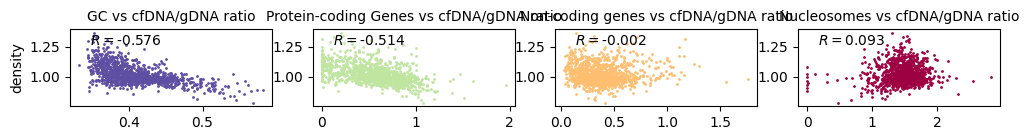

In [41]:
refseg,arrseg,nucseg,agseg,pcgseg,ncgseg,gcseg = segment_vs_genes(arr=rctdnas,ref=rctrls)
ratio = [arrseg[i]/refseg[i] for i in range(len(refseg))]
r1 = pearsonr(gcseg,ratio)[0]; 
r2 = pearsonr(pcgseg,ratio)[0]; 
r3 = pearsonr(ncgseg,ratio)[0]; 
r4 = pearsonr(nucseg,ratio)[0]
f, (a1, a2, a3, a4) = plt.subplots(1, 4, figsize=(12,1), width_ratios=[1, 1, 1, 1])
#a0.scatter(agseg,refseg,s=1,color=colors[0]);a0.set_title('All Genes',fontsize=10);a0.annotate('R='+str(round(r0,3)), (0.1, 0.8), xycoords='axes fraction')
a1.scatter(gcseg,ratio,s=1,color=colors[0]);a1.set_title('GC vs cfDNA/gDNA ratio',fontsize=10);a1.annotate(r'$R=$'+str(round(r1,3)), (0.1, 0.8), xycoords='axes fraction')
a2.scatter(pcgseg,ratio,s=1,color=colors[1]);a2.set_title('Protein-coding Genes vs cfDNA/gDNA ratio',fontsize=10);a2.annotate(r'$R=$'+str(round(r2,3)), (0.1, 0.8), xycoords='axes fraction')
a3.scatter(ncgseg,ratio,s=1,color=colors[2]);a3.set_title('Non-coding genes vs cfDNA/gDNA ratio',fontsize=10);a3.annotate(r'$R=$'+str(round(r3,3)), (0.1, 0.8), xycoords='axes fraction')
a4.scatter(nucseg,ratio,s=1,color=colors[3]);a4.set_title('Nucleosomes vs cfDNA/gDNA ratio',fontsize=10);a4.annotate(r'$R=$'+str(round(r4,3)), (0.1, 0.8), xycoords='axes fraction')
#a0.ticklabel_format(axis='y', style='sci', scilimits=(1,3))
a1.ticklabel_format(axis='y', style='sci', scilimits=(1,3));a1.set_ylabel('density')
a2.ticklabel_format(axis='y', style='sci', scilimits=(1,3))
a3.ticklabel_format(axis='y', style='sci', scilimits=(1,3))
a4.ticklabel_format(axis='y', style='sci', scilimits=(1,3))
plt.show()
#plt.savefig('new_suppl/ctDNA_cfDNA_ratio_corr_with_factors.png',bbox_inches='tight',dpi=120)

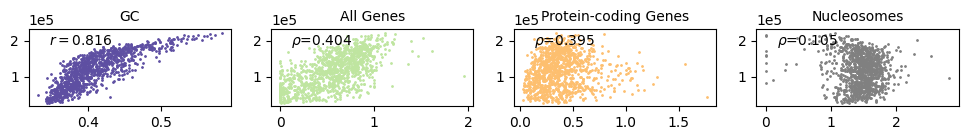

In [37]:
refseg,arrseg,nucseg,agseg,pcgseg,ncgseg,gcseg = segment_vs_genes()
r4 = pearsonr(gcseg,refseg)[0]; dataf = pd.DataFrame({'GC':gcseg,'All':agseg,'Pro':pcgseg,'Cov':refseg,'Non':ncgseg,'Nuc':nucseg})
r1 = pg.partial_corr(data=dataf,x='All',y='Cov',covar='GC').round(3)['r']['pearson']
r2 = pg.partial_corr(data=dataf,x='Pro',y='Cov',covar='GC').round(3)['r']['pearson']
r3 = pg.partial_corr(data=dataf,x='Nuc',y='Cov',covar='GC').round(3)['r']['pearson']
f, (a4, a1, a2, a3) = plt.subplots(1, 4, figsize=(12,1), width_ratios=[1, 1, 1, 1])
#a0.scatter(agseg,refseg,s=1,color=colors[0]);a0.set_title('All Genes',fontsize=10);a0.annotate('R='+str(round(r0,3)), (0.1, 0.8), xycoords='axes fraction')
a1.scatter(pcgseg,refseg,s=1,color=colors[1]);a1.set_title('All Genes',fontsize=10);a1.annotate(r'$\rho$='+str(round(r1,3)), (0.1, 0.8), xycoords='axes fraction')
a2.scatter(ncgseg,refseg,s=1,color=colors[2]);a2.set_title('Protein-coding Genes',fontsize=10);a2.annotate(r'$\rho$='+str(round(r2,3)), (0.1, 0.8), xycoords='axes fraction')
a3.scatter(nucseg,refseg,s=1,color='grey');a3.set_title('Nucleosomes',fontsize=10);a3.annotate(r'$\rho$='+str(round(r3,3)), (0.1, 0.8), xycoords='axes fraction')
a4.scatter(gcseg,refseg,s=1,color=colors[0]);a4.set_title('GC',fontsize=10);a4.annotate(r'$r=$'+str(round(r4,3)), (0.1, 0.8), xycoords='axes fraction')
#a0.ticklabel_format(axis='y', style='sci', scilimits=(1,3))
a1.ticklabel_format(axis='y', style='sci', scilimits=(1,3))
a2.ticklabel_format(axis='y', style='sci', scilimits=(1,3))
a3.ticklabel_format(axis='y', style='sci', scilimits=(1,3))
a4.ticklabel_format(axis='y', style='sci', scilimits=(1,3))
plt.show()
#plt.savefig('new_figures/fig.gDNA-genome-segment-vs-gc-genes-nucleosome-scatter-partial-corr.png',bbox_inches='tight',dpi=120)

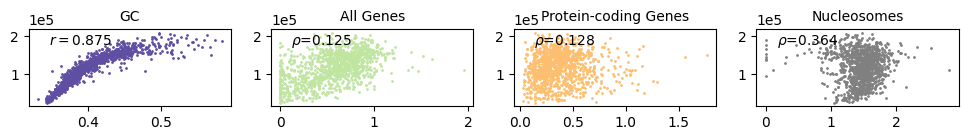

In [38]:
r4 = pearsonr(gcseg,arrseg)[0]; dataf = pd.DataFrame({'GC':gcseg,'All':agseg,'Pro':pcgseg,'Cov':arrseg,'Non':ncgseg,'Nuc':nucseg})
r1 = pg.partial_corr(data=dataf,x='All',y='Cov',covar='GC').round(3)['r']['pearson']
r2 = pg.partial_corr(data=dataf,x='Pro',y='Cov',covar='GC').round(3)['r']['pearson']
r3 = pg.partial_corr(data=dataf,x='Nuc',y='Cov',covar='GC').round(3)['r']['pearson']
f, (a4, a1, a2, a3) = plt.subplots(1, 4, figsize=(12,1), width_ratios=[1, 1, 1, 1])
#a0.scatter(agseg,refseg,s=1,color=colors[0]);a0.set_title('All Genes',fontsize=10);a0.annotate('R='+str(round(r0,3)), (0.1, 0.8), xycoords='axes fraction')
a1.scatter(pcgseg,arrseg,s=1,color=colors[1]);a1.set_title('All Genes',fontsize=10);a1.annotate(r'$\rho$='+str(round(r1,3)), (0.1, 0.8), xycoords='axes fraction')
a2.scatter(ncgseg,arrseg,s=1,color=colors[2]);a2.set_title('Protein-coding Genes',fontsize=10);a2.annotate(r'$\rho$='+str(round(r2,3)), (0.1, 0.8), xycoords='axes fraction')
a3.scatter(nucseg,arrseg,s=1,color='grey');a3.set_title('Nucleosomes',fontsize=10);a3.annotate(r'$\rho$='+str(round(r3,3)), (0.1, 0.8), xycoords='axes fraction')
a4.scatter(gcseg,arrseg,s=1,color=colors[0]);a4.set_title('GC',fontsize=10);a4.annotate(r'$r=$'+str(round(r4,3)), (0.1, 0.8), xycoords='axes fraction')
#a0.ticklabel_format(axis='y', style='sci', scilimits=(1,3))
a1.ticklabel_format(axis='y', style='sci', scilimits=(1,3))
a2.ticklabel_format(axis='y', style='sci', scilimits=(1,3))
a3.ticklabel_format(axis='y', style='sci', scilimits=(1,3))
a4.ticklabel_format(axis='y', style='sci', scilimits=(1,3))
plt.show()
#plt.savefig('new_figures/fig.cfDNA-genome-segment-vs-gc-genes-nucleosome-scatter-partial-corr.png',bbox_inches='tight',dpi=120)

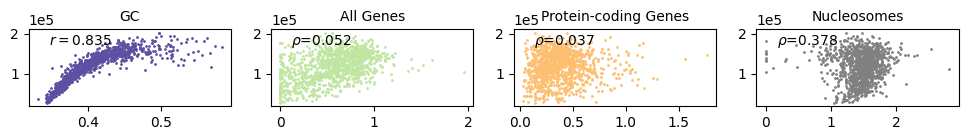

In [39]:
refseg,arrseg,nucseg,agseg,pcgseg,ncgseg,gcseg = segment_vs_genes(arr=rctdnas)
r4 = pearsonr(gcseg,arrseg)[0]; dataf = pd.DataFrame({'GC':gcseg,'All':agseg,'Pro':pcgseg,'Cov':arrseg,'Non':ncgseg,'Nuc':nucseg})
r1 = pg.partial_corr(data=dataf,x='All',y='Cov',covar='GC').round(3)['r']['pearson']
r2 = pg.partial_corr(data=dataf,x='Pro',y='Cov',covar='GC').round(3)['r']['pearson']
r3 = pg.partial_corr(data=dataf,x='Nuc',y='Cov',covar='GC').round(3)['r']['pearson']
f, (a4, a1, a2, a3) = plt.subplots(1, 4, figsize=(12,1), width_ratios=[1, 1, 1, 1])
#a0.scatter(agseg,refseg,s=1,color=colors[0]);a0.set_title('All Genes',fontsize=10);a0.annotate('R='+str(round(r0,3)), (0.1, 0.8), xycoords='axes fraction')
a1.scatter(pcgseg,arrseg,s=1,color=colors[1]);a1.set_title('All Genes',fontsize=10);a1.annotate(r'$\rho$='+str(round(r1,3)), (0.1, 0.8), xycoords='axes fraction')
a2.scatter(ncgseg,arrseg,s=1,color=colors[2]);a2.set_title('Protein-coding Genes',fontsize=10);a2.annotate(r'$\rho$='+str(round(r2,3)), (0.1, 0.8), xycoords='axes fraction')
a3.scatter(nucseg,arrseg,s=1,color='grey');a3.set_title('Nucleosomes',fontsize=10);a3.annotate(r'$\rho$='+str(round(r3,3)), (0.1, 0.8), xycoords='axes fraction')
a4.scatter(gcseg,arrseg,s=1,color=colors[0]);a4.set_title('GC',fontsize=10);a4.annotate(r'$r=$'+str(round(r4,3)), (0.1, 0.8), xycoords='axes fraction')
#a0.ticklabel_format(axis='y', style='sci', scilimits=(1,3))
a1.ticklabel_format(axis='y', style='sci', scilimits=(1,3))
a2.ticklabel_format(axis='y', style='sci', scilimits=(1,3))
a3.ticklabel_format(axis='y', style='sci', scilimits=(1,3))
a4.ticklabel_format(axis='y', style='sci', scilimits=(1,3))
plt.show()
#plt.savefig('new_figures/fig.ctDNA-genome-segment-vs-gc-genes-nucleosome-scatter-partial-corr.png',bbox_inches='tight',dpi=120)